In [1]:
import numpy as np

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

import tqdm
from tqdm import tqdm

import random
import pickle
import time

In [2]:
#loading data
data = np.load("trainingNormalized430Cut11BinsDATA2.npy")
allNormal = np.load("allNormal3.npy", allow_pickle=True)
# allAnomaly = np.load("allAnomaly3.npy", allow_pickle=True)

# test = allNormal[:]
# test = test.tolist()

# for i in allAnomaly:
#     test.append(i)

# print(len(test))

In [3]:
def makeWindows(data, numWindows):
    windows = []
    intervalLength = int(430 / numWindows)
    for mspec in range(len(data)):
        start = 0
        end = intervalLength
        for interval in range(numWindows):
            melspectrogram = data[mspec]
            window = melspectrogram[:,start:end]
            windows.append(window)
            start += intervalLength
            end += intervalLength
    return windows
        

In [4]:
def makeWindows2(data, numWindows):
    windows = []
    intervalLength = int(430 / numWindows)
    for mspec in tqdm(range(len(data))):
        start = 0
        end = intervalLength
        for interval in range(numWindows):
            melspectrogram = data[mspec]
            window = melspectrogram[:,start:end]
            windows.append([window, mspec, interval])
            start += intervalLength
            end += intervalLength
    return windows
    

In [5]:
#taking a sample size of 10,000
#8:2 split (training_data:testing_data ratio)
np.random.seed(1234)
np.random.shuffle(data)
training_data = data[:] #length of 8000
# testing_data = data[8000:10000] #length of 2000

windows = makeWindows(training_data, 43) #this makes the window size 11 x 10
# testWindows = makeWindows(testing_data, 5)

In [6]:
class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #starting size: (11,10)
            nn.Conv2d(1,32,3), #input: 11, 10 -> 9, 8
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3), #input: 4, 4 -> 2,2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2) #input: 2, 2 -> 1, 1
            #final: 1, 1
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), #input: 1,1 -> 3,3
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 6, stride=2, output_padding = (1,0)) #input: 3, 3 -> 11,10
            
            #final: 11,10
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x=self.decoder(x)
        return x

In [7]:
# windows[0].shape

In [8]:
# test = CAE()

# o = test.encoder(torch.from_numpy(windows[0].reshape(-1,1,11,86)).type(torch.float32))
# o.shape

In [9]:
#creating the batches - fan
#total windows will be 247,938
BATCH_SIZE = 31
BATCHES = []

copy = windows

seed = 0

iterations = int((len(copy))/BATCH_SIZE)
for i in range(iterations):
    random.seed(seed)
    start = random.randint(0, len(copy) - BATCH_SIZE)
    seed += 1
    end = start + BATCH_SIZE
    batch = copy[start:end]
    BATCHES.append(batch)
    copy = copy[:start] + copy[end:] #taking out the batch from the training_data
    #to prevent duplicate numbers from appearing across batches
   
print(len(copy))
print(f'Shape: {len(BATCHES)}, {len(BATCHES[0])}')

0
Shape: 2791, 65


In [10]:
#converting the python list to tensor

batched_training_data = np.array(BATCHES)
np.random.seed(2345)
np.random.shuffle(batched_training_data)
batched_training_data = torch.from_numpy(batched_training_data).type(torch.float32)

In [11]:
# len(BATCHES[0][0][0])

86

In [12]:
# batched_training_data.shape

torch.Size([2791, 65, 11, 86])

In [13]:
# y = allNormal[:5, 0]
# y2 = makeWindows(y, 5)
# y2= np.array(y2)
# np.random.seed(2345)
# np.random.shuffle(y2)
# print(y2.dtype)
# y2 = torch.from_numpy(y2).type(torch.float32)
# print(type(y2))


In [14]:
#training

model = CAE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

# size = 65

allNormalCut = allNormal[:65, 0]
allNormalCut = makeWindows(allNormalCut, 5)
allNormalCut = allNormalCut[:size]
allNormalCut = np.array(allNormalCut)

NUM_OF_EPOCH = 50

train_losses = []
val_losses = []

#outputs = []

# def test(testX):
#     testX = torch.from_numpy(testX).type(torch.float32)
#     outputs = model(testX.view(-1,1,11,10))
#     val_loss = criterion(outputs.view(-1,1,11,10), testX.view(-1,1,11,10))
#     return val_loss
with open("fan_1.log", "a") as f
    for epoch in range(NUM_OF_EPOCH):
        for i in range(len(batched_training_data)):
            output = model(batched_training_data[i].view(-1,1,11,10))
            loss = criterion(output.view(-1,1,11,10), batched_training_data[i].view(-1,1,11,10))
#             train_losses.append(loss.item())
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if i % 50 == 0:
                vloss = test(allNormalCut)
                val_losses.append(vloss)
                f.write(f"fan1,{round(time.time(),3)},{round(float(loss.item()), 4)},{round(float(vloss),4)}\n")
    #outputs.append((epoch, output, batched_training_data[i]))
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    np.save("fan_Losses1.npy", train_losses)

Epoch 0, Loss: 24.1652
Epoch 1, Loss: 15.4003
Epoch 2, Loss: 10.6046
Epoch 3, Loss: 8.2747
Epoch 4, Loss: 7.2132


In [15]:
batched_training_data[i].shape

torch.Size([65, 11, 86])

In [16]:
batched_training_data.shape

torch.Size([2791, 65, 11, 86])

In [17]:
import pickle

filename = 'model_20.pt'
pickle.dump(model, open(filename, 'wb'))

In [18]:
# model_5 = pickle.load(open('model_5.pt', 'rb'))

In [19]:
# testWindows[0].shape

42.12590789794922


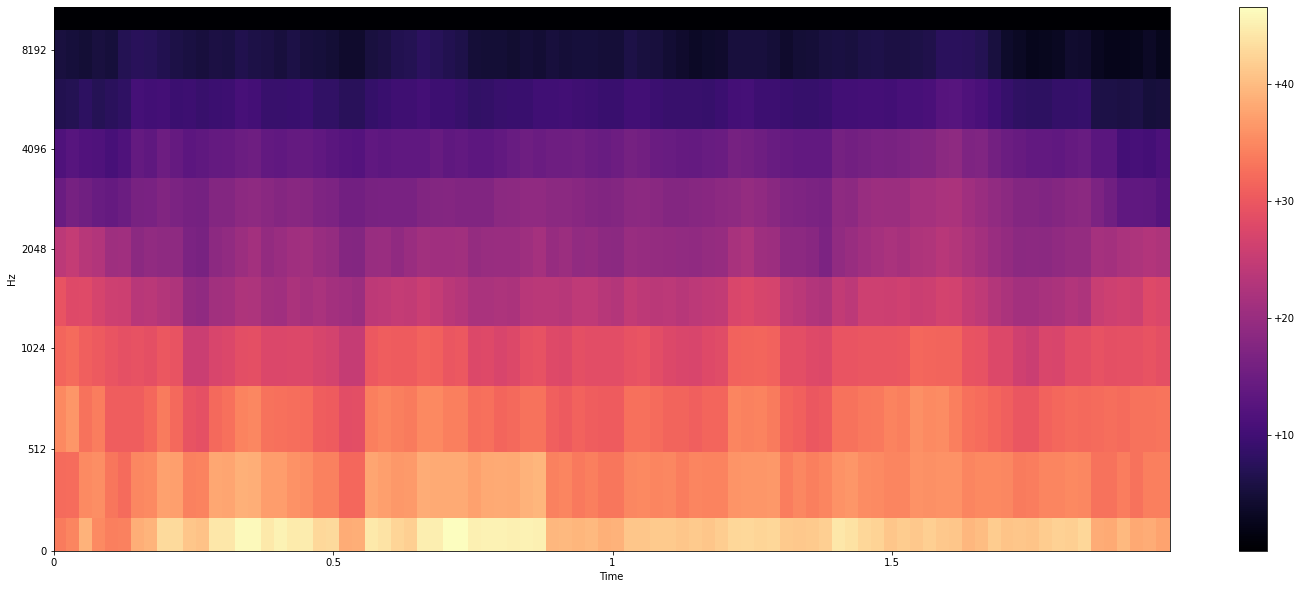

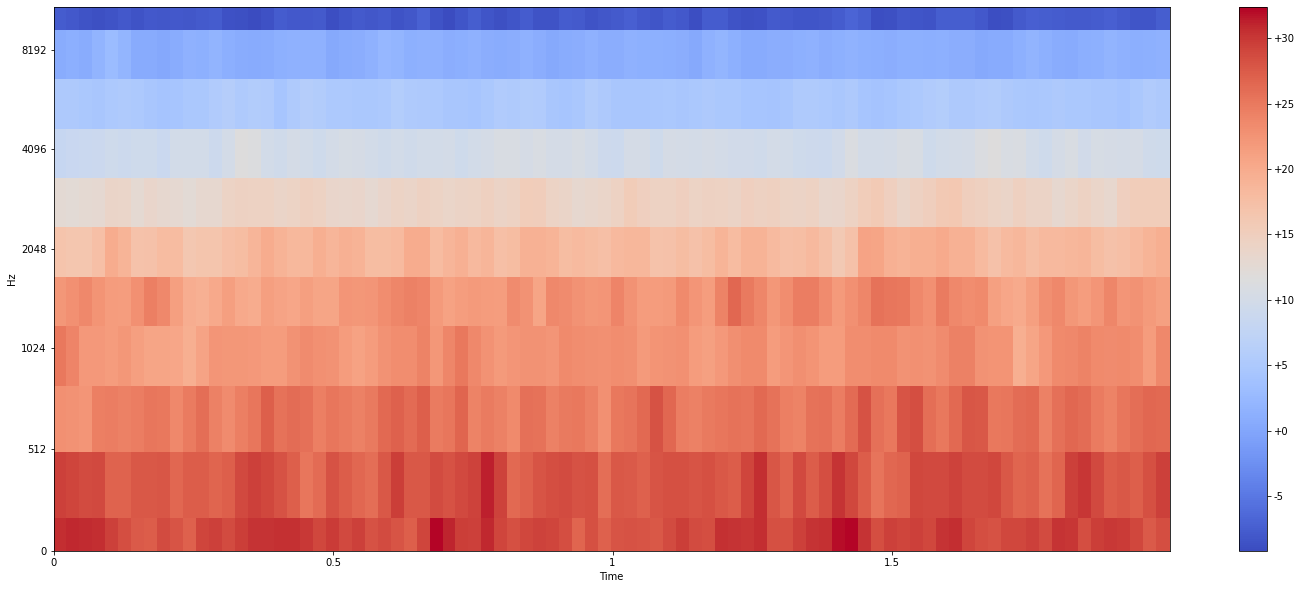

In [22]:
model = pickle.load(open('model_20.pt','rb'))
a = 100
#look at a = 1, it looks very similar
output = model(torch.from_numpy(windows[a].reshape(-1,1,11,10)).type(torch.float32))
# output2 = model(torch.from_numpy(testWindows[2000].reshape(-1,1,11,86)).type(torch.float32))

criterion = nn.MSELoss()
testing = criterion(output.view(-1,1,11,10), torch.from_numpy(windows[a]).type(torch.float32).view(-1,1,11,10))
print(testing.item())

#reconstructed
plt.figure(figsize=(25,10))
librosa.display.specshow(output.view(11,10).detach().numpy(), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

#actual
plt.figure(figsize=(25,10))
librosa.display.specshow(windows[a].reshape(11,10), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

